In [1]:
 ! pip install -q kaggle

In [2]:
 from google.colab import files
 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"derilraju","key":"097411653815596c519e950270a47158"}'}

In [3]:
 ! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 99% 1.14G/1.15G [00:19<00:00, 79.3MB/s]
100% 1.15G/1.15G [00:19<00:00, 62.8MB/s]


In [ ]:
!mkdir covid
! unzip covid19-radiography-database.zip -d covid

In [8]:
!pip install livelossplot

In [30]:
import os
import shutil
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, AveragePooling2D,Input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam

In [10]:
class_names = ['normal', 'viral', 'covid']
root_dir = '/content/covid/COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

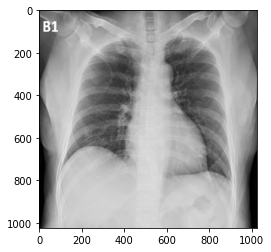

In [11]:
import matplotlib.image as mpimg
im= mpimg.imread('/content/covid/COVID-19 Radiography Database/train/covid/COVID-19 (10).png')
plt.imshow(im, cmap='gray')

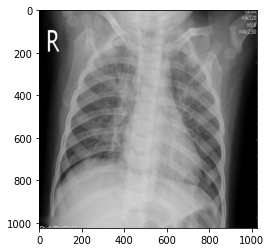

In [12]:
import matplotlib.image as mpimg
im= mpimg.imread('/content/covid/COVID-19 Radiography Database/train/viral/Viral Pneumonia (1).png')
plt.imshow(im, cmap='gray')

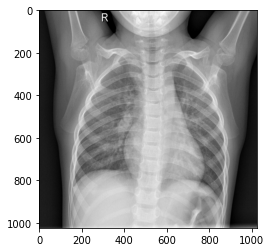

In [13]:
import matplotlib.image as mpimg
im= mpimg.imread('/content/covid/COVID-19 Radiography Database/train/normal/NORMAL (1).png')
plt.imshow(im, cmap='gray')

In [36]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   shear_range=0.2,
                                   zoom_range=0.3,
                                   horizontal_flip=True,
                                   fill_mode="nearest",
                                   validation_split=0.15)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/covid/COVID-19 Radiography Database/train',
    target_size=(224,224),
    batch_size=8,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    '/content/covid/COVID-19 Radiography Database/train', 
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='validation')
test_generator = test_datagen.flow_from_directory(
    '/content/covid/COVID-19 Radiography Database/test', 
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,
    class_mode='categorical',
)

Found 2394 images belonging to 3 classes.
Found 421 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(64,kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(128,kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(256,kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 111, 111, 32)      128       
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 54, 54, 64)        2

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from livelossplot import PlotLossesKerasTF
m = ModelCheckpoint('model1.h5',monitor='val_loss',save_best_only=False,save_weights_only=False,)
e = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
callbacks=[m, PlotLossesKerasTF()]

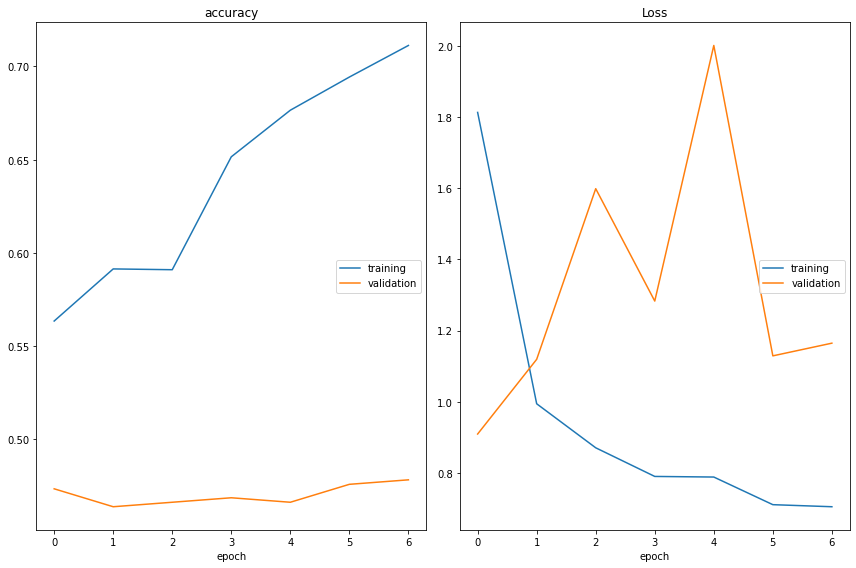

accuracy
	training         	 (min:    0.564, max:    0.711, cur:    0.711)
	validation       	 (min:    0.464, max:    0.478, cur:    0.478)
Loss
	training         	 (min:    0.705, max:    1.813, cur:    0.705)
	validation       	 (min:    0.909, max:    2.001, cur:    1.165)
74/74 [==============================] - 73s 993ms/step - loss: 0.7051 - accuracy: 0.7113 - val_loss: 1.1647 - val_accuracy: 0.4784
Epoch 00007: early stopping


In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // 32,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // 32,
    epochs = 80,callbacks=callbacks,verbose=1)

In [16]:
from tensorflow.keras.applications import VGG16, InceptionV3

In [17]:
baseModel = VGG16(include_top=False,weights='imagenet', input_tensor=Input(shape=(224,224,3)))

58892288/58889256 [==============================] - 1s 0us/step


In [24]:
head = baseModel.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Dropout(0.5)(head)
head = Flatten()(head)
head = Dense(64,activation='relu')(head)
head = Dropout(0.5)(head)
head = Dense(3, activation='softmax')(head)
model = Model(inputs=baseModel.input, outputs=head)
for layer in baseModel.layers:
  layer.trainable=False

In [25]:
opt = Adam(lr=1e-3, decay=1e-3/80)

In [27]:
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [28]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

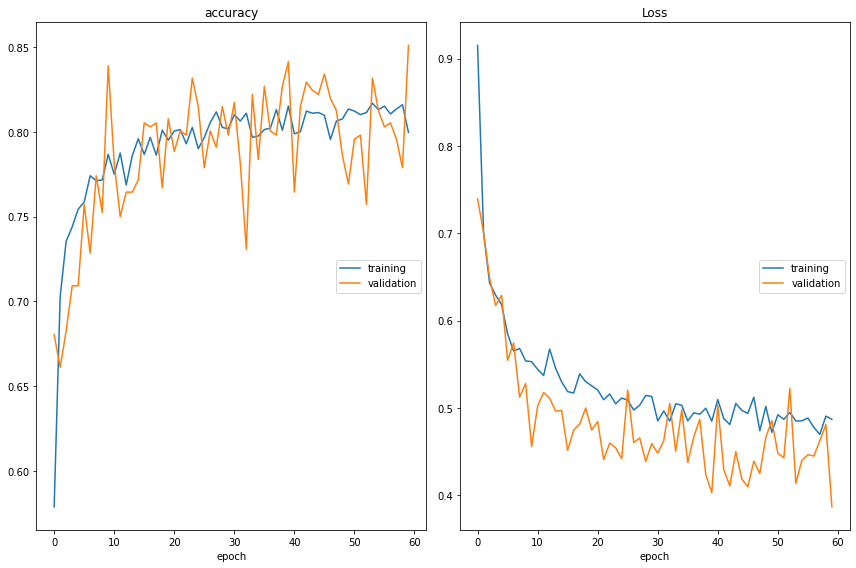

accuracy
	training         	 (min:    0.579, max:    0.817, cur:    0.800)
	validation       	 (min:    0.661, max:    0.851, cur:    0.851)
Loss
	training         	 (min:    0.470, max:    0.915, cur:    0.487)
	validation       	 (min:    0.387, max:    0.739, cur:    0.387)
299/299 [==============================] - 93s 312ms/step - loss: 0.4871 - accuracy: 0.7997 - val_loss: 0.3871 - val_accuracy: 0.8510
Epoch 61/80
 95/299 [========>.....................] - ETA: 54s - loss: 0.4434 - accuracy: 0.8342

KeyboardInterrupt: ignored

In [29]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples//8 ,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples//8 ,
    epochs = 80, callbacks=callbacks, verbose=1)

In [31]:
model = load_model('/content/model1.h5')

In [42]:
predict

array([[1.29303053e-01, 5.72078645e-01, 2.98618287e-01],
       [5.69831073e-01, 8.36322978e-02, 3.46536666e-01],
       [4.32974070e-01, 1.53633737e-04, 5.66872299e-01],
       [9.05250132e-01, 9.96546936e-04, 9.37532857e-02],
       [8.55379462e-01, 4.33158129e-02, 1.01304702e-01],
       [2.66145796e-01, 2.33640447e-01, 5.00213802e-01],
       [2.57216722e-01, 4.58106883e-02, 6.96972549e-01],
       [9.26867008e-01, 4.33144812e-03, 6.88014850e-02],
       [8.51328075e-01, 2.29732110e-03, 1.46374553e-01],
       [4.68245983e-01, 1.44393235e-01, 3.87360811e-01],
       [4.96791214e-01, 2.72143096e-01, 2.31065676e-01],
       [1.10247180e-01, 7.16597319e-01, 1.73155457e-01],
       [5.08530557e-01, 6.72210939e-04, 4.90797192e-01],
       [7.20246851e-01, 1.65395264e-03, 2.78099239e-01],
       [1.34812191e-01, 5.88698871e-02, 8.06317866e-01],
       [4.39836949e-01, 7.52851740e-02, 4.84877855e-01],
       [5.00398338e-01, 1.46513097e-02, 4.84950334e-01],
       [8.15505564e-01, 1.77801

In [38]:
predict = model.predict_generator(test_generator,steps=len(test_generator.filenames))

In [41]:
from sklearn.metrics import accuracy_score

In [48]:
acc = accuracy_score(test_generator.classes, np.argmax(predict,axis=1))

In [49]:
acc

0.7777777777777778